In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
!pip install opencv-python

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K
import cv2
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
import tensorflow as tf

In [5]:
def conv_block(x, filter_size, size, dropout, batch_norm=False):
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same",dilation_rate=2, kernel_initializer = 'he_normal')(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same",dilation_rate=2, kernel_initializer = 'he_normal')(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv


In [6]:
def conv_block_ritnet(x, filter_size, size, dropout, batch_norm=False):
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv


In [2]:
def Shallow_UNet(input_shape, inputs, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True, second=False, conv_1=[]):
    '''
    UNet, 
    
    '''
    # network structure
    FILTER_NUM = 64 # number of filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    

#     inputs = layers.Input(input_shape, dtype=tf.float32)

    # Downsampling layers
    # DownRes 1, convolution + pooling
    conv_128 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4, convolution only
    conv_16 = conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
   
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_16)
    if second:
        up_32 = layers.concatenate([up_32, conv_32, conv_1[-1]], axis=3)
    else:
        up_32 = layers.concatenate([up_32, conv_32], axis=3)
    up_conv_32 = conv_block(up_32, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    if second:
        up_64 = layers.concatenate([up_64, conv_64, conv_1[-2]], axis=3)
    else:
        up_64 = layers.concatenate([up_64, conv_64], axis=3)
    up_conv_64 = conv_block(up_64, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    if second:
        up_128 = layers.concatenate([up_128, conv_128, conv_1[-3]], axis=3)
    else:
        up_128 = layers.concatenate([up_128, conv_128], axis=3)
    up_conv_128 = conv_block(up_128, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
   

    # 1*1 convolutional layers
   
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel
    
    
    return conv_final,[conv_128, conv_64, conv_32]


In [7]:
def UNet(input_shape, inputs, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True, second=False, conv_1=[]):
    '''
    UNet, 
    
    '''
    # network structure
    FILTER_NUM = 64 # number of filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    

#     inputs = layers.Input(input_shape, dtype=tf.float32)

    # Downsampling layers
    # DownRes 1, convolution + pooling
    conv_128 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
   
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    if second:
        up_16 = layers.concatenate([up_16, conv_16, conv_1[3]], axis=3)
    else:
        up_16 = layers.concatenate([up_16, conv_16], axis=3)
    up_conv_16 = conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    if second:
        up_32 = layers.concatenate([up_32, conv_32, conv_1[2]], axis=3)
    else:
        up_32 = layers.concatenate([up_32, conv_32], axis=3)
    up_conv_32 = conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    if second:
        up_64 = layers.concatenate([up_64, conv_64, conv_1[1]], axis=3)
    else:
        up_64 = layers.concatenate([up_64, conv_64], axis=3)
    up_conv_64 = conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
   
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    if second:
        up_128 = layers.concatenate([up_128, conv_128,conv_1[0]], axis=3)
    else:
        up_128 = layers.concatenate([up_128, conv_128], axis=3)
    up_conv_128 = conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
   
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel
    
    
    return conv_final,[conv_128, conv_64, conv_32, conv_16]


In [6]:
def UNetRIT(input_shape, inputs, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True, second=False, conv_1=[]):
    '''
    UNet, 
    
    '''
    # network structure
    FILTER_NUM = 64 # number of filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    

#     inputs = layers.Input(input_shape, dtype=tf.float32)

    # Downsampling layers
    # DownRes 1, convolution + pooling
    conv_128 = conv_block_ritnet(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = conv_block_ritnet(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = conv_block_ritnet(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = conv_block_ritnet(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = conv_block_ritnet(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
   
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    if second:
        up_16 = layers.concatenate([up_16, conv_16, conv_1[3]], axis=3)
    else:
        up_16 = layers.concatenate([up_16, conv_16], axis=3)
    up_conv_16 = conv_block_ritnet(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    if second:
        up_32 = layers.concatenate([up_32, conv_32, conv_1[2]], axis=3)
    else:
        up_32 = layers.concatenate([up_32, conv_32], axis=3)
    up_conv_32 = conv_block_ritnet(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    if second:
        up_64 = layers.concatenate([up_64, conv_64, conv_1[1]], axis=3)
    else:
        up_64 = layers.concatenate([up_64, conv_64], axis=3)
    up_conv_64 = conv_block_ritnet(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
   
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    if second:
        up_128 = layers.concatenate([up_128, conv_128,conv_1[0]], axis=3)
    else:
        up_128 = layers.concatenate([up_128, conv_128], axis=3)
    up_conv_128 = conv_block_ritnet(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
   
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel
    
    
    return conv_final,[conv_128, conv_64, conv_32, conv_16]

In [3]:
def double_Unet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):
    inputs1 = layers.Input(input_shape, dtype=tf.float32)
    output1, pre_conv = Shallow_UNet(input_shape, inputs1, NUM_CLASSES=1, dropout_rate=0.2, batch_norm=True)
    inputs2 = inputs1 * output1
    output2,_ =  Shallow_UNet(input_shape, inputs2, NUM_CLASSES=1, dropout_rate=0.2, 
                      batch_norm=True, second=True, conv_1=pre_conv)
    conv_final = layers.concatenate([output1, output2], axis=3)
    # 1*1 convolutional layers
   
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(conv_final)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel
    
    model = models.Model(inputs1, conv_final, name="DoubleUNet")
    return model
    


In [6]:
input_shape = (128,128,3)
model = double_Unet(input_shape, NUM_CLASSES=1, dropout_rate=0.35, batch_norm=True)

In [10]:
model.summary()

Model: "DoubleUNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                        

 conv2d_8 (Conv2D)              (None, 8, 8, 1024)   4719616     ['max_pooling2d_3[0][0]']        
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 8, 8, 1024)  4096        ['conv2d_8[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_8 (Activation)      (None, 8, 8, 1024)   0           ['batch_normalization_8[0][0]']  
                                                                                                  
 conv2d_9 (Conv2D)              (None, 8, 8, 1024)   9438208     ['activation_8[0][0]']           
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 8, 8, 1024)  4096        ['conv2d_9[0][0]']               
 rmalizati

 concatenate_3 (Concatenate)    (None, 128, 128, 19  0           ['up_sampling2d_3[0][0]',        
                                2)                                'dropout[0][0]']                
                                                                                                  
 conv2d_16 (Conv2D)             (None, 128, 128, 64  110656      ['concatenate_3[0][0]']          
                                )                                                                 
                                                                                                  
 batch_normalization_16 (BatchN  (None, 128, 128, 64  256        ['conv2d_16[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 activation_16 (Activation)     (None, 128, 128, 64  0           ['batch_normalization_16[0][0]'] 
          

                                                                                                  
 batch_normalization_24 (BatchN  (None, 32, 32, 256)  1024       ['conv2d_24[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_24 (Activation)     (None, 32, 32, 256)  0           ['batch_normalization_24[0][0]'] 
                                                                                                  
 dropout_11 (Dropout)           (None, 32, 32, 256)  0           ['activation_24[0][0]']          
                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 16, 16, 256)  0          ['dropout_11[0][0]']             
                                                                                                  
 conv2d_25

 ormalization)                                                                                    
                                                                                                  
 activation_32 (Activation)     (None, 32, 32, 256)  0           ['batch_normalization_32[0][0]'] 
                                                                                                  
 dropout_15 (Dropout)           (None, 32, 32, 256)  0           ['activation_32[0][0]']          
                                                                                                  
 up_sampling2d_6 (UpSampling2D)  (None, 64, 64, 256)  0          ['dropout_15[0][0]']             
                                                                                                  
 concatenate_6 (Concatenate)    (None, 64, 64, 512)  0           ['up_sampling2d_6[0][0]',        
                                                                  'dropout_10[0][0]',             
          

In [11]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        img = cv2.resize(img, (128,128),interpolation = cv2.INTER_NEAREST)
        if img is not None:
            images.append(img)
    return images

In [12]:
import matplotlib.pyplot as plt 
from tensorflow.python.keras import losses

In [11]:
folder= "C:/Users/anark/Downloads/seg_data/train_images"
images = load_images_from_folder(folder)
image_array = np.array(images)

In [12]:
folder= "C:/Users/anark/Downloads/seg_data/train_masks"
masks = load_images_from_folder(folder)
mask_array = np.array(masks)[:,:,:,0]

In [13]:
img = image_array/255

img.shape

mas = mask_array/255

mas[mas > 0.5] = 1
mas[mas <= 0.5] = 0
mas.shape

(2500, 128, 128)

In [14]:
image_array.shape, mask_array.shape

((2500, 128, 128, 3), (2500, 128, 128))

In [30]:
# Split Dataset
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(img, mas, test_size=0.15, random_state=1)

In [31]:
X_train = X_train.astype(np.float16)
X_val = X_val.astype(np.float16)
y_train = y_train.astype(np.float16)
y_val = y_val.astype(np.float16)

In [32]:
X_train.dtype, X_val.dtype, y_train.dtype, y_val.dtype

(dtype('float16'), dtype('float16'), dtype('float16'), dtype('float16'))

In [33]:
X_train.shape,y_train.shape

((2125, 128, 128, 3), (2125, 128, 128))

In [34]:
np.unique(y_val),np.unique(y_train)

(array([0., 1.], dtype=float16), array([0., 1.], dtype=float16))

In [35]:
np.max(X_val),np.max(X_train),np.max(y_val),np.max(y_train)

(1.0, 1.0, 1.0, 1.0)

In [15]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=bce_dice_loss,
              metrics=[dice_loss])

# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "DoubleUNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 64) 0           batch_normalization[0][0]        
_________________________________________________________________________________________

In [38]:
import datetime

In [25]:
save_model_path = 'C:/Users/anark/Downloads/seg_data/tmp/weights_DoubleUnet_1.hdf5'
log_dir = "C:/Users/anark/Downloads/seg_data/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_dice_loss', save_best_only=True, verbose=1)

In [39]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
    
scheduler_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [40]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_dice_loss',
    min_delta=0,
    patience=20,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

In [44]:
#Step 4: Fit the u-net model
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('C:/Users/anark/Downloads/seg_data/models/unet_STARE_AttentionUnet_1.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.fit(X_train,y_train,epochs=50,batch_size=8,validation_data=(X_val, y_val),callbacks=[tensorboard_callback,model_checkpoint,scheduler_callback])

Epoch 1/50
266/266 [==============================] - ETA: 0s - loss: 0.7159 - dice_loss: 0.3769
Epoch 00001: loss improved from inf to 0.71594, saving model to C:/Users/anark/Downloads/seg_data/models/unet_STARE_AttentionUnet_1.hdf5
266/266 [==============================] - 125s 471ms/step - loss: 0.7159 - dice_loss: 0.3769 - val_loss: 0.6816 - val_dice_loss: 0.3590 - lr: 0.0010
Epoch 2/50
266/266 [==============================] - ETA: 0s - loss: 0.5571 - dice_loss: 0.3095
Epoch 00002: loss improved from 0.71594 to 0.55706, saving model to C:/Users/anark/Downloads/seg_data/models/unet_STARE_AttentionUnet_1.hdf5
266/266 [==============================] - 123s 463ms/step - loss: 0.5571 - dice_loss: 0.3095 - val_loss: 0.4767 - val_dice_loss: 0.2676 - lr: 0.0010
Epoch 3/50
266/266 [==============================] - ETA: 0s - loss: 0.4512 - dice_loss: 0.2581
Epoch 00003: loss improved from 0.55706 to 0.45117, saving model to C:/Users/anark/Downloads/seg_data/models/unet_STARE_AttentionUn

Epoch 22/50
266/266 [==============================] - ETA: 0s - loss: 0.0863 - dice_loss: 0.0460
Epoch 00022: loss improved from 0.08866 to 0.08628, saving model to C:/Users/anark/Downloads/seg_data/models/unet_STARE_AttentionUnet_1.hdf5
266/266 [==============================] - 135s 508ms/step - loss: 0.0863 - dice_loss: 0.0460 - val_loss: 0.0975 - val_dice_loss: 0.0485 - lr: 3.0119e-04
Epoch 23/50
266/266 [==============================] - ETA: 0s - loss: 0.0844 - dice_loss: 0.0448
Epoch 00023: loss improved from 0.08628 to 0.08438, saving model to C:/Users/anark/Downloads/seg_data/models/unet_STARE_AttentionUnet_1.hdf5
266/266 [==============================] - 132s 497ms/step - loss: 0.0844 - dice_loss: 0.0448 - val_loss: 0.1081 - val_dice_loss: 0.0530 - lr: 2.7253e-04
Epoch 24/50
266/266 [==============================] - ETA: 0s - loss: 0.0805 - dice_loss: 0.0428
Epoch 00024: loss improved from 0.08438 to 0.08047, saving model to C:/Users/anark/Downloads/seg_data/models/unet_ST

Epoch 43/50
266/266 [==============================] - ETA: 0s - loss: 0.0512 - dice_loss: 0.0274
Epoch 00043: loss improved from 0.05184 to 0.05122, saving model to C:/Users/anark/Downloads/seg_data/models/unet_STARE_AttentionUnet_1.hdf5
266/266 [==============================] - 139s 521ms/step - loss: 0.0512 - dice_loss: 0.0274 - val_loss: 0.0996 - val_dice_loss: 0.0424 - lr: 3.6883e-05
Epoch 44/50
266/266 [==============================] - ETA: 0s - loss: 0.0505 - dice_loss: 0.0270
Epoch 00044: loss improved from 0.05122 to 0.05048, saving model to C:/Users/anark/Downloads/seg_data/models/unet_STARE_AttentionUnet_1.hdf5
266/266 [==============================] - 138s 517ms/step - loss: 0.0505 - dice_loss: 0.0270 - val_loss: 0.0968 - val_dice_loss: 0.0412 - lr: 3.3373e-05
Epoch 45/50
266/266 [==============================] - ETA: 0s - loss: 0.0499 - dice_loss: 0.0267
Epoch 00045: loss improved from 0.05048 to 0.04992, saving model to C:/Users/anark/Downloads/seg_data/models/unet_ST

In [41]:
save_model_path = 'C:/Users/anark/Downloads/seg_data/tmp/weights_DoubleUnet_2.hdf5'
log_dir = "C:/Users/anark/Downloads/seg_data/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_dice_loss', save_best_only=True, verbose=1)

In [24]:
model = double_Unet(input_shape, NUM_CLASSES=1, dropout_rate=0.35, batch_norm=True)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=bce_dice_loss,
              metrics=[dice_loss])

# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "DoubleUNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_190 (Conv2D)             (None, 128, 128, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_190 (BatchN (None, 128, 128, 64) 256         conv2d_190[0][0]                 
__________________________________________________________________________________________________
activation_190 (Activation)     (None, 128, 128, 64) 0           batch_normalization_190[0][0]    
_________________________________________________________________________________________

In [43]:
#Step 4: Fit the u-net model
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('C:/Users/anark/Downloads/seg_data/models/unet_STARE_AttentionUnet_2.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.fit(X_train,y_train,epochs=200,batch_size=8,validation_data=(X_val, y_val),callbacks=[tensorboard_callback,model_checkpoint,scheduler_callback,early_stop])

Epoch 1/200
266/266 [==============================] - ETA: 0s - loss: 0.7184 - dice_loss: 0.3779
Epoch 00001: loss improved from inf to 0.71842, saving model to C:/Users/anark/Downloads/seg_data/models/unet_STARE_AttentionUnet_2.hdf5
266/266 [==============================] - 128s 483ms/step - loss: 0.7184 - dice_loss: 0.3779 - val_loss: 0.6984 - val_dice_loss: 0.3846 - lr: 0.0010
Epoch 2/200
266/266 [==============================] - ETA: 0s - loss: 0.5580 - dice_loss: 0.3099
Epoch 00002: loss improved from 0.71842 to 0.55804, saving model to C:/Users/anark/Downloads/seg_data/models/unet_STARE_AttentionUnet_2.hdf5
266/266 [==============================] - 127s 477ms/step - loss: 0.5580 - dice_loss: 0.3099 - val_loss: 0.4708 - val_dice_loss: 0.2686 - lr: 0.0010
Epoch 3/200
266/266 [==============================] - ETA: 0s - loss: 0.4505 - dice_loss: 0.2577
Epoch 00003: loss improved from 0.55804 to 0.45050, saving model to C:/Users/anark/Downloads/seg_data/models/unet_STARE_Attentio

Epoch 22/200
266/266 [==============================] - ETA: 0s - loss: 0.0861 - dice_loss: 0.0458
Epoch 00022: loss improved from 0.08841 to 0.08613, saving model to C:/Users/anark/Downloads/seg_data/models/unet_STARE_AttentionUnet_2.hdf5
266/266 [==============================] - 127s 477ms/step - loss: 0.0861 - dice_loss: 0.0458 - val_loss: 0.1004 - val_dice_loss: 0.0500 - lr: 3.0119e-04
Epoch 23/200
266/266 [==============================] - ETA: 0s - loss: 0.0837 - dice_loss: 0.0444
Epoch 00023: loss improved from 0.08613 to 0.08373, saving model to C:/Users/anark/Downloads/seg_data/models/unet_STARE_AttentionUnet_2.hdf5
266/266 [==============================] - 129s 487ms/step - loss: 0.0837 - dice_loss: 0.0444 - val_loss: 0.0944 - val_dice_loss: 0.0472 - lr: 2.7253e-04
Epoch 24/200
266/266 [==============================] - ETA: 0s - loss: 0.0803 - dice_loss: 0.0426
Epoch 00024: loss improved from 0.08373 to 0.08032, saving model to C:/Users/anark/Downloads/seg_data/models/unet

Epoch 43/200
266/266 [==============================] - ETA: 0s - loss: 0.0513 - dice_loss: 0.0274
Epoch 00043: loss improved from 0.05184 to 0.05131, saving model to C:/Users/anark/Downloads/seg_data/models/unet_STARE_AttentionUnet_2.hdf5
266/266 [==============================] - 120s 451ms/step - loss: 0.0513 - dice_loss: 0.0274 - val_loss: 0.0879 - val_dice_loss: 0.0381 - lr: 3.6883e-05
Epoch 44/200
266/266 [==============================] - ETA: 0s - loss: 0.0505 - dice_loss: 0.0270
Epoch 00044: loss improved from 0.05131 to 0.05051, saving model to C:/Users/anark/Downloads/seg_data/models/unet_STARE_AttentionUnet_2.hdf5
266/266 [==============================] - 120s 452ms/step - loss: 0.0505 - dice_loss: 0.0270 - val_loss: 0.0874 - val_dice_loss: 0.0378 - lr: 3.3373e-05
Epoch 45/200
266/266 [==============================] - ETA: 0s - loss: 0.0502 - dice_loss: 0.0268
Epoch 00045: loss improved from 0.05051 to 0.05021, saving model to C:/Users/anark/Downloads/seg_data/models/unet

Epoch 64/200
266/266 [==============================] - ETA: 0s - loss: 0.0459 - dice_loss: 0.0247
Epoch 00064: loss improved from 0.04591 to 0.04589, saving model to C:/Users/anark/Downloads/seg_data/models/unet_STARE_AttentionUnet_2.hdf5
266/266 [==============================] - 120s 452ms/step - loss: 0.0459 - dice_loss: 0.0247 - val_loss: 0.0875 - val_dice_loss: 0.0367 - lr: 4.5166e-06
Epoch 65/200
266/266 [==============================] - ETA: 0s - loss: 0.0458 - dice_loss: 0.0246
Epoch 00065: loss improved from 0.04589 to 0.04576, saving model to C:/Users/anark/Downloads/seg_data/models/unet_STARE_AttentionUnet_2.hdf5
266/266 [==============================] - 120s 453ms/step - loss: 0.0458 - dice_loss: 0.0246 - val_loss: 0.0874 - val_dice_loss: 0.0367 - lr: 4.0868e-06
Epoch 66/200
266/266 [==============================] - ETA: 0s - loss: 0.0457 - dice_loss: 0.0246
Epoch 00066: loss improved from 0.04576 to 0.04569, saving model to C:/Users/anark/Downloads/seg_data/models/unet

Epoch 88/200
266/266 [==============================] - ETA: 0s - loss: 0.0451 - dice_loss: 0.0243
Epoch 00088: loss did not improve from 0.04504
266/266 [==============================] - 119s 447ms/step - loss: 0.0451 - dice_loss: 0.0243 - val_loss: 0.0876 - val_dice_loss: 0.0366 - lr: 4.0973e-07
Epoch 89/200
266/266 [==============================] - ETA: 0s - loss: 0.0450 - dice_loss: 0.0242
Epoch 00089: loss improved from 0.04504 to 0.04495, saving model to C:/Users/anark/Downloads/seg_data/models/unet_STARE_AttentionUnet_2.hdf5
266/266 [==============================] - 120s 452ms/step - loss: 0.0450 - dice_loss: 0.0242 - val_loss: 0.0876 - val_dice_loss: 0.0366 - lr: 3.7074e-07
Epoch 90/200
266/266 [==============================] - ETA: 0s - loss: 0.0451 - dice_loss: 0.0243
Epoch 00090: loss did not improve from 0.04495
266/266 [==============================] - 119s 447ms/step - loss: 0.0451 - dice_loss: 0.0243 - val_loss: 0.0876 - val_dice_loss: 0.0366 - lr: 3.3546e-07
Epoch 

Epoch 115/200
266/266 [==============================] - ETA: 0s - loss: 0.0451 - dice_loss: 0.0243
Epoch 00115: loss did not improve from 0.04491
266/266 [==============================] - 120s 452ms/step - loss: 0.0451 - dice_loss: 0.0243 - val_loss: 0.0876 - val_dice_loss: 0.0367 - lr: 2.7536e-08
Epoch 116/200
266/266 [==============================] - ETA: 0s - loss: 0.0450 - dice_loss: 0.0242
Epoch 00116: loss did not improve from 0.04491
266/266 [==============================] - 120s 451ms/step - loss: 0.0450 - dice_loss: 0.0242 - val_loss: 0.0876 - val_dice_loss: 0.0366 - lr: 2.4916e-08
Epoch 117/200
266/266 [==============================] - ETA: 0s - loss: 0.0450 - dice_loss: 0.0243
Epoch 00117: loss did not improve from 0.04491
266/266 [==============================] - 120s 451ms/step - loss: 0.0450 - dice_loss: 0.0243 - val_loss: 0.0876 - val_dice_loss: 0.0366 - lr: 2.2545e-08
Epoch 118/200
266/266 [==============================] - ETA: 0s - loss: 0.0450 - dice_loss: 0.02

In [44]:
"Completed at : " + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

'Completed at : 20220830-050451'

In [136]:
folder= "C:/Users/anark/Downloads/seg_data/test_images"
images = load_images_from_folder(folder)
image_array = np.array(images)

In [18]:
folder= "C:/Users/anark/Downloads/seg_data/test_masks"
masks = load_images_from_folder(folder)
masks_array = np.array(masks)[:,:,:,0]

In [137]:
img = image_array/255

img.shape

mas = masks_array/255

mas[mas > 0.5] = 1
mas[mas <= 0.5] = 0
mas.shape

(135, 128, 128)

In [20]:
img = img.astype(np.float16)
mas = mas.astype(np.float16)

In [21]:
model.load_weights(r"C:\Users\anark\Downloads\seg_data\models\unet_STARE_AttentionUnet_2.hdf5")

In [22]:
pred = model.predict(img)

In [23]:
img.shape,mas.shape,pred.shape

((135, 128, 128, 3), (135, 128, 128), (135, 128, 128, 1))

In [24]:
source = pred[89]*img[89]

In [25]:
target = pred[96]*img[96]

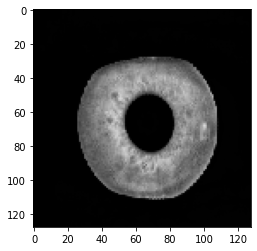

In [26]:
plt.imshow(source)

In [27]:
import cv2 as cv

In [51]:
gray = cv.cvtColor(source, cv.COLOR_BGR2GRAY)

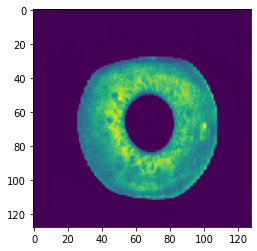

In [52]:
plt.imshow(gray)

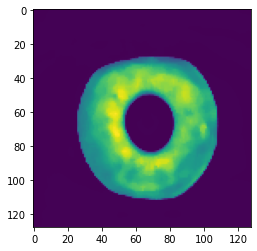

In [53]:
gray = cv.medianBlur(gray, 5)
plt.imshow(gray)

In [28]:
rad_detect = pred[89].copy()
rad_detect[rad_detect > 0.5] = 1
rad_detect[rad_detect <= 0.5] = 0
rad_detect.shape

(128, 128, 1)

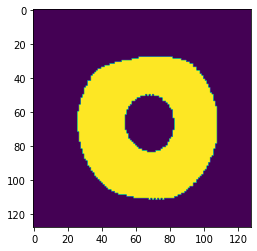

In [86]:
plt.imshow(rad_detect[:,:,0])

In [30]:
rad_detect.shape

(128, 128, 1)

In [31]:
from skimage import data, color, img_as_ubyte
from skimage.feature import canny,peak_local_max
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter


In [32]:
edges = canny(rad_detect[:,:,0], sigma=3)
edges1 = canny(rad_detect[:,:,0])
edges2 = canny(rad_detect[:,:,0], sigma=3)

Text(0.5, 1.0, 'Canny filter, $\\sigma=3$')

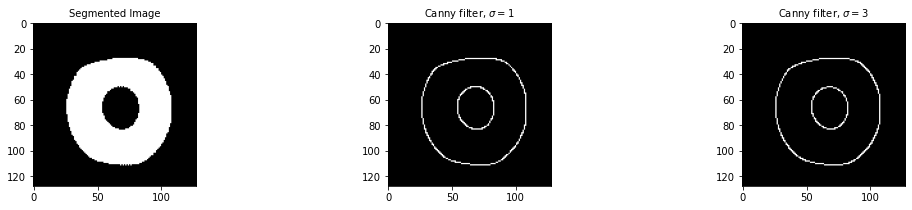

In [33]:
# display results
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 3))

ax[0].imshow(rad_detect, cmap='gray')
ax[0].set_title('Segmented Image', fontsize=10)

ax[1].imshow(edges1, cmap='gray')
ax[1].set_title(r'Canny filter, $\sigma=1$', fontsize=10)

ax[2].imshow(edges2, cmap='gray')
ax[2].set_title(r'Canny filter, $\sigma=3$', fontsize=10)


In [34]:
points = np.argwhere(edges2>0)

In [35]:
center, radius = cv2.minEnclosingCircle(points)
print('center:', center, 'radius:', radius)
result = rad_detect.copy()
x = int(center[1])
y = int(center[0])
rad = int(radius)
cir = cv2.circle(result, (x,y), rad, (255,255,255), 1)

center: (68.17549896240234, 67.09602355957031) radius: 44.74633026123047


In [84]:
cv2.imwrite('Image_from_array.png', rad_detect)
rad_detect_cv = cv2.imread('Image_from_array.png')
edged = cv2.Canny(rad_detect_cv, 1, 2)
circles = cv2.HoughCircles(edged, cv2.HOUGH_GRADIENT,1,5,
                            param1=50,param2=30,minRadius=0,maxRadius=40)

In [85]:
circles

array([[[68.5, 67.5, 15. ]]], dtype=float32)

In [102]:
np.unique(edged)

array([  0, 255], dtype=uint8)

In [109]:
ret, _  = cv2.threshold(edged, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
circles = cv2.HoughCircles(edged, cv2.HOUGH_GRADIENT, 1, 7, param1=100, param2=30, minRadius=5,
                               maxRadius=100)
circles

array([[[65.5, 68.5, 42.2],
        [71.5, 64.5, 17.7]]], dtype=float32)

In [98]:
def daugman_normalizaiton(image, height, width, r_in, r_out):
    thetas = np.arange(0, 2 * np.pi, 2 * np.pi / width)  # Theta values
    r_out = r_in + r_out
    # Create empty flatten image
    flat = np.zeros((height,width, 3))
    circle_x = int(image.shape[0] / 2)
    circle_y = int(image.shape[1] / 2)

    for i in range(width):
        for j in range(height):
            theta = thetas[i]  # value of theta coordinate
            r_pro = j / height  # value of r coordinate(normalized)

            # get coordinate of boundaries
            Xi = circle_x + r_in * np.cos(theta)
            Yi = circle_y + r_in * np.sin(theta)
            Xo = circle_x + r_out * np.cos(theta)
            Yo = circle_y + r_out * np.sin(theta)

            # the matched cartesian coordinates for the polar coordinates
            Xc = (1 - r_pro) * Xi + r_pro * Xo
            Yc = (1 - r_pro) * Yi + r_pro * Yo

            color = image[int(Xc)][int(Yc)]  # color of the pixel

            flat[j][i] = color
    return flat  

In [133]:
dgn = daugman_normalizaiton(source,42,360,17,42)

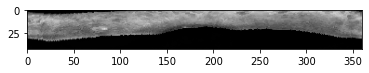

In [134]:
plt.imshow(dgn)

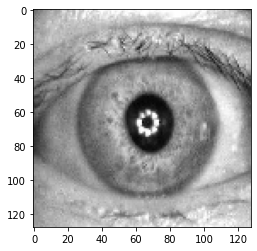

In [138]:
plt.imshow(img[89])

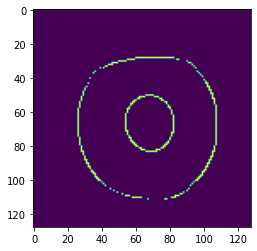

In [232]:
ref2 = edges2 - cir[:,:,0]
ref2[ref2 > 0.5] = 1
ref2[ref2 <= 0.5] = 0
plt.imshow(ref2)

Text(0.5, 1.0, 'Canny filter, $\\sigma=3$')

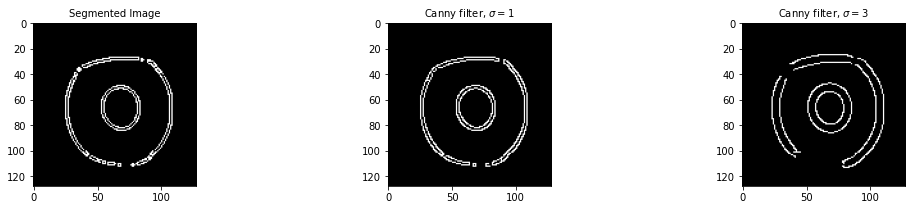

In [228]:

edges3 = canny(ref2, sigma=0)
edges4 = canny(ref2)
edges5 = canny(ref2, sigma=3)

# display results
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 3))

ax[0].imshow(edges3, cmap='gray')
ax[0].set_title('Segmented Image', fontsize=10)

ax[1].imshow(edges4, cmap='gray')
ax[1].set_title(r'Canny filter, $\sigma=1$', fontsize=10)

ax[2].imshow(edges5, cmap='gray')
ax[2].set_title(r'Canny filter, $\sigma=3$', fontsize=10)

In [238]:
points = np.argwhere(edges5>0)

In [239]:
center, radius = cv2.minEnclosingCircle(points)
print('center:', center, 'radius:', radius)

center: (68.16584014892578, 67.75985717773438) radius: 47.477848052978516


In [ ]:
cv2.min

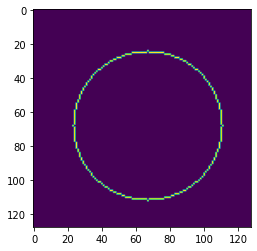

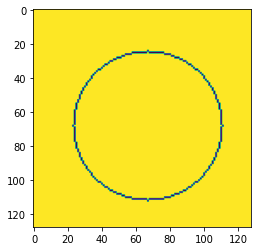

In [175]:
plt.imshow(rad-cir)

array([0., 1.], dtype=float32)

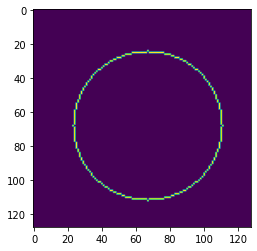

In [142]:
for radius, h in zip(hough_radii, hough_res):
    # For each radius, extract two circles
    num_peaks = 2
    peaks = peak_local_max(h, num_peaks=num_peaks,threshold_abs=50)
    centers.extend(peaks)
    accums.extend(h[peaks[:, 0], peaks[:, 1]])
    radii.extend([radius] * num_peaks)

<ipython-input-146-4084bde00aac>:2: FutureWarning: Pass-through of possibly RGB images in gray2rgb is deprecated. In version 0.19, input arrays will always be considered grayscale, even if the last dimension has length 3 or 4. To prevent this warning and ensure compatibility with future versions, detect RGB images outside of this function.
  image = color.gray2rgb(image)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


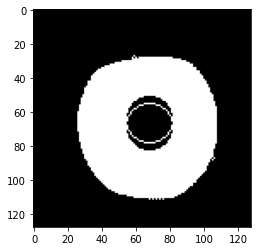

In [146]:
# Draw the most prominent 5 circles
image = color.gray2rgb(image)
for idx in np.argsort(accums)[::-1][:5]:
    center_x, center_y = centers[idx]
    radius = radii[idx]
    cx, cy = circle_perimeter(center_y, center_x, radius)
    image[cy, cx] = (220, 20, 20)

plt.imshow(image, cmap=plt.cm.gray)

In [145]:
# Draw the ellipse on the original image
cy, cx = ellipse_perimeter(yc, xc, a, b, orientation)
# Draw the edge (white) and the resulting ellipse (red)
edges = color.gray2rgb(edges)
edges[cy, cx] = (250, 0, 0)

fig2, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(8, 4), sharex=True,
                                sharey=True,
                                subplot_kw={'adjustable':'box-forced'})

ax1.set_title('Original picture')
ax1.imshow(rad_detect)

ax2.set_title('Edge (white) and result (red)')
ax2.imshow(edges)

plt.show()

ValueError: 'box-forced' is not a valid value for adjustable; supported values are 'box', 'datalim'

<Figure size 576x288 with 0 Axes>

In [30]:
model.load_weights(r"C:\Users\anark\Downloads\seg_data\models\unet_STARE_AttentionUnet_2.hdf5")

In [31]:
pred = model.predict(img)

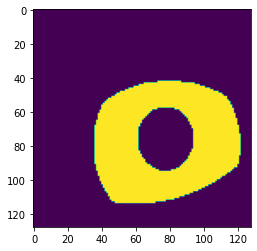

In [35]:
plt.imshow(mas[35].astype('int'))

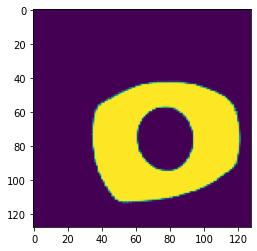

In [36]:
plt.imshow(pred[35])

In [34]:
model.evaluate(img,mas)

5/5 [==============================] - 8s 2s/step - loss: 0.0881 - dice_loss: 0.0373


[0.08806893974542618, 0.0373283252120018]